# MNIST: exploring the "confusion" range of failed classifications

 ##### QUESTION: What is the distance of weight values for two top predicted classes and is there a correlation between that distance and cases when net is correct vs. wrong?
 
 The purpose of this work is to explore such cases when a simple NN fails to classify digits correctly on MNIST dataset and to see if there is an identifiable pattern in prediction weights it produces in such cases that could signal that network is "confused" or unsure about which class to assign to a digit it "sees".
 
 Indeed, at the end of this notebook we see that when two or more neurons of final layer fire with weights values that are very close to each other, the chances are, we have an incorrect answer. 

In [30]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [4]:
#load MNIST data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True, seed = 42)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


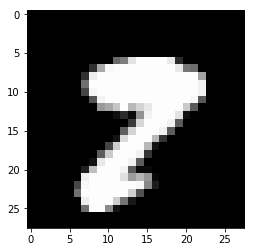

In [29]:
#quick sanity check
plt.imshow(mnist.train.images[121].reshape(28,28),cmap='gist_gray')

#### Is this 7 or 9? 
This is one of the cases in MNIST dataset where simple NN would fail to give a correct answer (in this case it will declare this to be 7).
What we will see at the end of this exploration that indeed both 7 and 9 classes have fired with weights that are much closer to each other statistically then in cases when network is quite sure about hte answer. 

(note: if you run this notebook, you might get a different digit/image at that index)

## Train a simple NN using Tensorflow

#### First, we are going to build a very simple neural net with just one layer using tensorflow

In [6]:
# set up tensorflow variables
x = tf.placeholder(tf.float32,shape=[None,784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# create the graph
y = tf.matmul(x,W) + b 
y_true = tf.placeholder(tf.float32,[None,10])

# final touches
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

train = optimizer.minimize(cross_entropy)

### Train the net and record results

Because I want to take a look at each failed case separately I am going to train the network on a full MNIST train set in one swoop and save it. In the following steps we will load our model and then iterattively show each trained example again to collect more information about the failed cases.

In [7]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for step in range(1000):
        
        batch_x , batch_y = mnist.train.next_batch(100)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y})
    
    # collecting results | yes, we are showing train results to our network again, not test ones. 
    # This is because we want to see which ones are "wrong"
    pred = sess.run(y,feed_dict={x:mnist.train.images,y_true:mnist.train.labels})

    # a quick check to see how our simple net is doing when shown test data
    matches = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))
    print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels})); # uncomment ; to see results during training

0.907


In [22]:
pd.DataFrame(pred).head()

,0,1,2,3,4,5,6,7,8,9
0,1.676900,-5.741533,-1.638761,-0.249522,-1.254141,5.337316,8.687561,-6.483205,0.487494,-0.822095
1,-6.740296,-5.600336,4.584312,-3.270462,4.543511,2.263459,11.023166,-9.201675,2.366873,0.031466
2,5.334924,-3.053740,-2.127701,2.198727,-2.465643,5.572421,3.656022,-0.946957,-2.249527,-5.918521
3,-2.193953,-11.770525,-4.233252,1.374942,2.758558,2.855701,-5.265783,5.095157,2.391254,8.987921
4,0.583938,-3.290595,-3.018085,10.909310,-2.337984,6.751018,-6.130802,1.000923,-0.295089,-4.172624


##### This is what we got as a result: a collection of final prediction weights for each class. You can see that some neurons fire positively, some negatively. The top weight is being used as a final prediction by our network. 

### Now let's gather information about top 2 weights in output layer

In [9]:

# don't mind all the commented stuff. I was curious to look 'deeper' into which classes fire and might come back to this later.
# for now, we are going to be looking only at top 2 predictions

#we're going to be anulling values of argmax to extract each consecutive results value, co we'll do taht on a copy
pred_copy = pred.copy()

results = {}
results['1_arg'] = []
results['1_weight'] = []
results['2_arg'] = []
results['2_weight'] = []
# results['3_arg'] = []
# results['3_weight'] = []
# results['4_arg'] = []
# results['4_weight'] = []


for i in range(pred_copy.shape[0]):

    # get first results prediction                 
    results['1_arg'].append(pred_copy[i].argmax())
    results['1_weight'].append(pred_copy[i][results['1_arg'][i]])

    #reset it in the list                
    pred_copy[i][results['1_arg'][i]] = 0

    # now, get second results prediction                
    results['2_arg'].append(pred_copy[i].argmax())
    results['2_weight'].append(pred_copy[i][results['2_arg'][i]])     
    
#     pred_copy[i][results['2_arg'][i]] = 0

#     results['3_arg'].append(pred_copy[i].argmax())
#     results['3_weight'].append(pred_copy[i][results['3_arg'][i]]) 
         
#     pred_copy[i][results['3_arg'][i]] = 0
    
#     results['4_arg'].append(pred_copy[i].argmax())
#     results['4_weight'].append(pred_copy[i][results['4_arg'][i]])  


#### Next, lets add info about which class was predicted and whether NN got it right or wrong

In [ ]:
#### Lets put all that into a pandas dataframe. It will be easier to manipulate and analyze results this way

results = pd.DataFrame(results)
pred_df = pd.DataFrame(pred)

results['Y_hat'] = pd.Series([x.argmax() for x in pred]) # predicted class
results['Y'] = pd.Series([x.argmax() for x in mnist.train.labels]) # truth
results['correct'] = results['Y']==results['Y_hat'] # do they match?

In [10]:
# OK. here is what the table of all our top prediction looks like at this point.
results.head()

,1_arg,1_weight,2_arg,2_weight,Y_hat,Y,correct
0,6,8.687561,5,5.337316,6,6,True
1,6,11.023166,2,4.584312,6,6,True
2,5,5.572421,0,5.334924,5,3,False
3,9,8.987921,7,5.095157,9,9,True
4,3,10.909310,5,6.751018,3,3,True


 In case #2 both top two predictions ("5" and "0") were actually incorrect. The digit NN was given was "3".
 
 Note that the difference in weights for these two predictions is very small as opposed to other examples where answer was correct. This is exactly an example of what we are going to try to prove by the end of this notebook: that wrong cases fire very simmilar top prediction weights in constrast to cases when NN get's it right. 

####  A side experiment:
I am really curious to see how many neurons/classes have fired positively for a given case; this could be interresting in relation to detecting our "confusion" cases

In [11]:
pred = pd.DataFrame(pred)
pos = pred.apply(lambda x: [1 if y>0 else 0 for y in x], axis = 1)
pos.head()

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,1,1,0,1,0
1,0,0,1,0,1,1,1,0,1,1
2,1,0,0,1,0,1,1,0,0,0
3,0,0,0,1,1,1,0,1,1,1
4,1,0,0,1,0,1,0,1,0,0


In [12]:
# now let's count them and put it back to our dataframe
results['count'] = pos.T.sum()
results.head()

,1_arg,1_weight,2_arg,2_weight,Y_hat,Y,correct,count
0,6,8.687561,5,5.337316,6,6,True,4
1,6,11.023166,2,4.584312,6,6,True,6
2,5,5.572421,0,5.334924,5,3,False,4
3,9,8.987921,7,5.095157,9,9,True,6
4,3,10.909310,5,6.751018,3,3,True,4


#### Now let's take a look at what we got

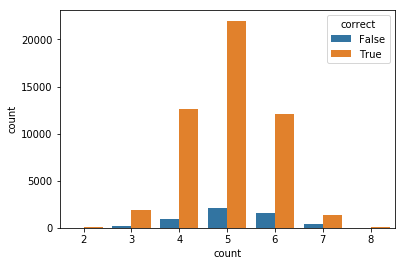

In [13]:
sns.countplot(x="count", data=results, hue="correct")

#### Analysis: 

1. In most cases on average of 5 (or half) classes fire positively in the output layer.
2. There really seem to be no apparent correlation between how many classes fire positively and whether answer is correct or not. 
3. The interresting finding here is that network always fires positively on at least two classes. There are absolutely no cases where only one output neuron produces a positive result. Same thing for the count of negative weights. Interresting. 

### Now, here comes the part we all are here for! 
#### Lets compare weight distances of top two classes for correct and incorrect cases

Let's take a look at how close the weight of top two predictions are and if there is any correlation with accounts of failed cases

In [14]:
results['diff'] = abs(results['1_weight'] - results['2_weight'])
results.head()

,1_arg,1_weight,2_arg,2_weight,Y_hat,Y,correct,count,diff
0,6,8.687561,5,5.337316,6,6,True,4,3.350245
1,6,11.023166,2,4.584312,6,6,True,6,6.438853
2,5,5.572421,0,5.334924,5,3,False,4,0.237497
3,9,8.987921,7,5.095157,9,9,True,6,3.892764
4,3,10.909310,5,6.751018,3,3,True,4,4.158292


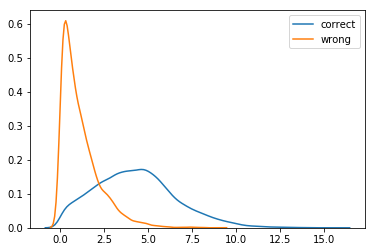

In [15]:
correct = results[results['correct']==True]
wrong = results[results['correct']==False]

sns.kdeplot(correct['diff'], label="correct")
sns.kdeplot(wrong['diff'], label="wrong")
plt.legend();

### Perfect! 
In the graph above we can clearly see that when weights of top two predicted classes are very close to each other, the chances are, our net is getting it wrong, or in other words, is being "confused" by a certain image of a digit. It looks like most cases where weigts differ by less than 2.5 we most likely have a wrong results. 

This <2.5 diff is what I call a "confusion range"

Q.E.D. 

In my next work I am going to attemp to "de-confuse" our network by making it "look closer" at a digit when output weighs are in this confusion range